## M5 Forecast Competition - Accuracy

This notebook is a product for submission into the [M5 Forecast Competition](https://www.kaggle.com/c/m5-forecasting-accuracy) with more information from the organizer, [MOFC](https://mofc.unic.ac.cy/m5-competition/). The ultimate goal of the competition is "... to advance the theory of forecasting and improve its utilization by business and non-profit organizations".

In [ ]:
!pip3 freeze

absl-py==0.9.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
asgiref==3.2.7
astor==0.8.1
astropy==4.0.1.post1
astunparse==1.6.3
atari-py==0.2.6
atomicwrites==1.4.0
attrs==19.3.0
audioread==2.1.8
autograd==1.3
Babel==2.8.0
backcall==0.1.0
beautifulsoup4==4.6.3
bleach==3.1.5
blis==0.4.1
bokeh==1.4.0
boto==2.49.0
boto3==1.13.19
botocore==1.16.19
Bottleneck==1.3.2
branca==0.4.1
bs4==0.0.1
CacheControl==0.12.6
cachetools==3.1.1
catalogue==1.0.0
certifi==2020.4.5.1
cffi==1.14.0
chainer==6.5.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.4.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.2.1
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.5
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.3
Cython==0.29.19
daft==0.0.4
dask==2.12.0
dataclasses==0.7
datascience==0.10.6
decorator==4.4.2
defusedxml==0.6.0
descartes==1.1.0
dill==0.3.1.1
distributed==1.25.3
Django==3.0.6
dlib==19.18.0
docopt==0.6.2
docutils==0.15.2
dopami

### Credits

This first section of this notebook creating a cleaned dataframe is based off [M5 under-0.50 optimized](https://www.kaggle.com/poedator/m5-under-0-50-optimized) by [@poedator](https://www.kaggle.com/poedator) on Kaggle.

In [ ]:
  %tensorflow_version 2.x

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from  datetime import datetime, timedelta
import gc
import lightgbm as lgb
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=[16,12])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

In [ ]:
# Removing some warnings see here:
# https://stackoverflow.com/questions/40845304/runtimewarning-numpy-dtype-size-changed-may-indicate-binary-incompatibility
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

# Section 1: Load Data and Benchmark

### 1A: Load data and set data types

In [ ]:
CAL_DTYPES = {"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [ ]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [ ]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv('drive/My Drive/m5_forecast_accuracy/sell_prices.csv', dtype = PRICE_DTYPES)
    prices = reduce_mem_usage(prices)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("drive/My Drive/m5_forecast_accuracy/calendar.csv", dtype = CAL_DTYPES)
    cal = reduce_mem_usage(cal)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("drive/My Drive/m5_forecast_accuracy/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

Memory reduction function based on min and max of series credit to @hiroyuki_kageyama on Qiita:  [https://qiita.com/hiroyuki_kageyama/items/02865616811022f79754](https://qiita.com/hiroyuki_kageyama/items/02865616811022f79754)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics: #numericsのデータ型の範囲内のときに処理を実行. データの最大最小値を元にデータ型を効率的なものに変更
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def create_fea(dt):
    lags = [1, 7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [1, 7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [ ]:
FIRST_DAY = 3*365 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [ ]:
%%time
df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

Mem. usage decreased to 45.77 Mb (22.2% reduction)
Mem. usage decreased to  0.06 Mb (18.9% reduction)
CPU times: user 17.2 s, sys: 2.46 s, total: 19.7 s
Wall time: 23 s


In [ ]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float16       
 19  snap_TX       float16       
 20  snap_WI       float16       
 21  sell_price    float16       
dtypes: datetime64[ns](1), float16(4), float32(1), int16(12), int8(2)

In [ ]:
%%time

create_fea(df)
df.shape

CPU times: user 4min 42s, sys: 3.48 s, total: 4min 45s
Wall time: 4min 45s


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 37 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float16       
 19  snap_TX       float16       
 20  snap_WI       float16       
 21  sell_price    float16       
 22  lag_1         float32       
 23  lag_7         float32       
 

In [ ]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,lag_28,rmean_1_1,rmean_7_1,rmean_28_1,rmean_1_7,rmean_7_7,rmean_28_7,rmean_1_28,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,12.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,15.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2


### Please Credit dante.haywood at gmail dot com for the rest of the notebook

In [ ]:
# Dataset for testing functions, etc
tsdf = df.loc[df.id == df.id[0]]
ts = tsdf.sales
tsdf

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,lag_28,rmean_1_1,rmean_7_1,rmean_28_1,rmean_1_7,rmean_7_7,rmean_28_7,rmean_1_28,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1095,0.0,2014-01-27,11353,1,3,1,2014,0,0,0,0,0.0,0.0,0.0,8.257812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,27
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1096,0.0,2014-01-28,11353,5,4,1,2014,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,28
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1097,0.0,2014-01-29,11353,6,5,1,2014,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,29
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1098,0.0,2014-01-30,11353,4,6,1,2014,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,30
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1099,0.0,2014-01-31,11353,0,7,1,2014,0,0,0,0,0.0,0.0,0.0,8.257812,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23871244,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1909,1.0,2016-04-20,11612,6,5,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,1.0,0.0,2.0,1.0,0.0,2.0,1.000000,0.857143,1.857143,0.928571,1.071429,1.142857,16,2,20
23871245,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1910,3.0,2016-04-21,11612,4,6,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,1.0,1.0,0.0,1.0,1.0,0.0,1.142857,0.571429,1.714286,0.892857,1.071429,1.142857,16,2,21
23871246,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1911,0.0,2016-04-22,11612,0,7,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,3.0,1.0,1.0,3.0,1.0,1.0,1.428571,0.714286,1.428571,1.000000,1.000000,1.142857,16,2,22
24084670,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1912,1.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,8.382812,0.0,3.0,1.0,0.0,3.0,1.0,1.285714,1.000000,1.428571,0.964286,1.071429,1.035714,16,2,23


In [ ]:
ts.index

Int64Index([       0,        1,        2,        3,        4,        5,
                   6,    76524,    76525,    76526,
            ...
            45540172, 45753596, 45753597, 45753598, 45753599, 45753600,
            45753601, 45753602, 45966991, 45966992],
           dtype='int64', length=1913)

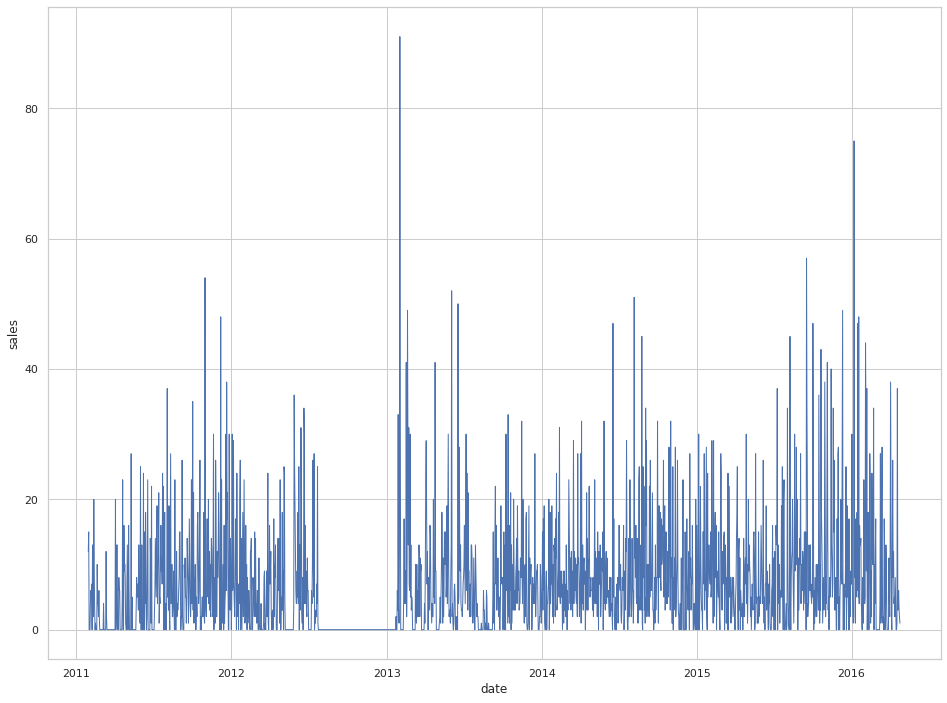

In [ ]:
plt.figure(figsize=[16,12])
sns.lineplot(data=tsdf, x='date', y='sales', palette="tab10", linewidth=1)

# Section 2: Benchmark models
## 1B: Create Benchmarks

### Moving Average

In [ ]:
# Utility Error
class ParameterError(Exception):
  pass

In [ ]:
# Calculate root mean squared scaled error
def rmsse(orig_series, pred_series, h=1, intermittent = True):
  '''
  Calculates Root Mean Scaled Squared Error as defined in competitor's guide.

  Parameters
  ----------
  orig_series: A numpy compatible object of the original series.

  pred_series: A numpy compatible object of a model fit.

  h: The forecast horizon assumed to be appended on the tail of orig_series and
  pred_series. A value of 1 assumes no forecast and no averaging occurs. NOTE:
  CHANGE FOR CLARITY.

  intermittent: If the RMSSE should be calculated for areas of series' value 
  below 0.

  Returns
  -------
  The RMSSE
  '''

  s1 = np.array(orig_series)
  s2 = np.array(pred_series)

  if intermittent:
    nz_idx = s1 > 0
    s1 = s1[nz_idx]
    s2 = s2[nz_idx]

  # Squared error
  se = np.sum(np.square(s1 - s2))
  # Scaled diff
  # Account for instances where only 1 nonzero value is seen
  if len(s1) > 1:
    sdiff = ( 1 / (len(s1) - 1) ) * np.sum(np.square(s1[1:] - np.diff(s1))) + 1e-7
  else:
    sdiff = np.sum(np.square(s1[1:] - np.diff(s1))) + 1e-7

  rmsse = np.sqrt( 1/h * (se / sdiff) )

  return rmsse

In [ ]:
def moving_average(series, windows, h=0):
  '''
  Calculates rolling mean using provided time windows. If multiple windows are
  given, outputs a list of MA series with their respective window.

  Parameters
  ----------
  series: A Pandas Series object to calculate the MA on.

  windows: An iterable object which lists the number of previous levels to be 
  considered.

  h: A forecast horizon for prediction. h = 0 means no prediction.


  Returns
  -------
  A dictionary with the following items:
    'series': The original series modeled.
    'in_sample_fit': A pandas DataFrame of requested moving averages.
    'forecast': A pandas DataFrame with predictions up to h.
  '''

  rolling_means = []
  preds_list = []

  for w in windows:
    rolling_mean = series.rolling(window=w).mean()
    rolling_mean[:w-1] = series[:w-1]
    rolling_mean.name = f'MA{w}'
    rolling_means.append(rolling_mean)

    if h > 0:
      preds = rolling_mean[-w:]

      for i in range(h):
        # Do not need to calculate rolling mean again for full series, only last
        pred = preds[-w:].rolling(window=w).mean()[-1:]
        preds = preds.append(pred, ignore_index = True)

      # Only keep the predicted entries
      preds = preds.iloc[w:]
      preds = preds.reset_index(drop=True)
      preds = preds.rename(f'hMA{w}')

    preds_list.append(preds)

  preds_df = pd.DataFrame(preds_list).T
  rolling_means = pd.DataFrame(rolling_means).T
  
  return_dict = {
      'series': series,
      'in_sample_fit': rolling_means,
      'forecast': preds_df,
  }

  return return_dict

In [ ]:
# Test MA
mas = moving_average(ts, [4,3,2], h=20)
mas

{'forecast':         hMA4      hMA3      hMA2
 0   5.812500  3.333333  2.000000
 1   4.140625  3.000000  1.750000
 2   4.175781  2.777778  1.875000
 3   4.282227  3.037037  1.812500
 4   4.602783  2.938272  1.843750
 5   4.300354  2.917695  1.828125
 6   4.340286  2.964335  1.835938
 7   4.381413  2.940101  1.832031
 8   4.406209  2.940710  1.833984
 9   4.357065  2.948382  1.833008
 10  4.371243  2.943064  1.833496
 11  4.378983  2.944052  1.833252
 12  4.378375  2.945166  1.833374
 13  4.371417  2.944094  1.833313
 14  4.375004  2.944437  1.833344
 15  4.375945  2.944566  1.833328
 16  4.375185  2.944366  1.833336
 17  4.374388  2.944456  1.833332
 18  4.375130  2.944463  1.833334
 19  4.375162  2.944428  1.833333,
 'in_sample_fit':             MA4        MA3   MA2
 0         12.00  12.000000  12.0
 1         15.00  15.000000  13.5
 2          0.00   9.000000   7.5
 3          6.75   5.000000   0.0
 4          3.75   0.000000   0.0
 ...         ...        ...   ...
 45753600  11.25  

### Exponential Smoothing

In [ ]:
# Utility functions for smoothing params
# Mainly used to limit compute for changes in parameters <.01
def check_smoothing_params(params):
  for p in params:
      if (p * 100) - int(p * 100) > 1e-3:
        raise ParameterError("Only 2 significant digits for smoothing parameters are accepted. Received {}".format(p))
      if (p > 0.99) or (p < 1e-3):
        raise ParameterError("Smoothing parameters must be between 0 and 1 and greater than 0.001. Received {}".format(p))


In [ ]:
def exponential_smoothing(series, alphas, h = 0):
  '''
  Calculates exponential smoothing model on given series and smoothing params.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  alphas: An iterable object of smoothing parameters which currently accepts 
  any value. Values over 2 significant figures are not allowed currently.

  h: Integer. The number of time steps for a forecast horizon

  Returns
  -------
  A dictionary with the following items:
    'series': The original series modeled.
    'in_sample_fit': A pandas DataFrame of requested SES models.
    'forecast': A pandas DataFrame with predictions up to h.
  '''

  check_smoothing_params(alphas)
  
  # Append smoothed series to this list
  ES_ALL = []
  preds_all = []

  # For each alpha listed,
  for a in alphas:
    name = 'ES_a{:0>2d}'.format(int(np.around(a, 2) * 100))
    ES = pd.Series(series.iloc[0])
    ES = ES.append(pd.Series(series.iloc[1]))
    # iterate over the series creating another smoothed series
    for idx in range(1, len(series)-1):
      ES = ES.append(pd.Series(a * series.iloc[idx] + (1 - a) * ES.iloc[idx - 1]))
  
    if h > 0:
      ES_preds = [ES.iloc[-2], ES.iloc[-1]]
      for idx in range(1, h+1):
        ES_preds.append(a * ES_preds[idx] + (1 - a) * ES_preds[idx - 1])
      
      # Remove first two observations used for initialization
      ES_preds = ES_preds[2:]
      ES_preds = pd.Series(ES_preds)
      ES_preds = ES_preds.rename('h' + name)
      preds_all.append(ES_preds)

    # Rename for merging later
    ES.name = name
    ES = ES.reset_index(drop=True)
    ES_ALL.append(ES)

  ES_ALL = pd.DataFrame(ES_ALL).T
  preds_df = pd.DataFrame(preds_all).T

  return_dict = {
      'series': series,
      'in_sample_fit': ES_ALL,
      'forecast': preds_df,
  }


  return return_dict
  

In [ ]:
ses = exponential_smoothing(ts, [0.1, 0.2], 2)
ses

{'forecast':     hES_a10   hES_a20
 0  8.423532  7.909758
 1  6.393864  5.562925, 'in_sample_fit':          ES_a10     ES_a20
 0     12.000000  12.000000
 1     15.000000  15.000000
 2     12.300000  12.600000
 3     13.500000  12.000000
 4     11.070000  10.080000
 ...         ...        ...
 1908   6.701661   5.650338
 1909   9.304565  10.053929
 1910   6.631495   5.720270
 1911   8.674109   8.643143
 1912   6.168345   4.976216
 
 [1913 rows x 2 columns], 'series': 0           12.0
 1           15.0
 2            0.0
 3            0.0
 4            0.0
             ... 
 45753600     4.0
 45753601     6.0
 45753602     3.0
 45966991     2.0
 45966992     1.0
 Name: sales, Length: 1913, dtype: float32}

### Double Exponential Smoothing

In [ ]:
def double_exponential_smoothing(series, alphas, betas, h=0):
  '''
  Calculates double exponential smoothing model on given series and smoothing params.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  alphas: An iterable object of smoothing parameters. Values over 2 significant figures are not allowed.

  beta: An iterable object of secondary smoothing parameters. Values over 2 significant figures are not allowed.

  h: Integer. The number of time steps in the future for prediction.

  Returns
  -------
  A dictionary with the following items:
    'series': The original series modeled.
    'in_sample_fit': A pandas DataFrame of requested SES models.
    'forecast': A pandas DataFrame with predictions up to h.
  '''

  s = np.array(series)
  check_smoothing_params(alphas)
  check_smoothing_params(betas)
  
  # Append smoothed series to this list
  DBL_ES_ALL = []
  preds_all = []

  # For each alpha listed,
  for a in alphas:
    # and each beta listed,
    for b in betas:
      DBL_ES = [series.iloc[0]]
      # iterate over the series creating another smoothed series
      for idx in range(1, len(series)):
        if idx == 1:
          level, trend = series.iloc[0], series.iloc[1] - series.iloc[0]
        if idx >= len(series):
          val = series.iloc[-1]
        else:
          val = series.iloc[idx]

        last_level, level = level, a * val + (1 - a) * (level + trend)
        trend = b * (level - last_level) + (1 - b) * trend
        DBL_ES.append(level + trend)

      if h > 0:
        preds = [DBL_ES[-2], DBL_ES[-1]]
        for i in range(1, h+1):
          if idx == 1:
            level, trend = preds[0], preds[1] - preds[0]
          else:
            val = preds[i]
          last_level, level = level, a * val + (1 - a) * (level + trend)
          trend = b * (level - last_level) + (1 - b) * trend
          preds.append(level + trend)

        # Remove first two obs that were used for initialization
        preds = preds[2:]
        preds = pd.Series(preds)
        preds = preds.rename('hDBL_ES_a{:0>2d}_b{:0>2d}'.format(int(a * 100), int(b * 100)))
        preds_all.append(preds)


      DBL_ES = pd.Series(DBL_ES)
      # Rename for merging later
      DBL_ES = DBL_ES.rename('DBL_ES_a{:0>2d}_b{:0>2d}'.format(int(a * 100), int(b * 100)))
      DBL_ES_ALL.append(DBL_ES)

  DBL_ES_ALL = pd.DataFrame(DBL_ES_ALL).T
  preds_all = pd.DataFrame(preds_all).T

  return_dict = {
      'series': series,
      'in_sample_fit': DBL_ES_ALL,
      'forecast': preds_all,
  }

  return return_dict

In [ ]:
des = double_exponential_smoothing(ts, [0.3,0.2], [0.2, 0.1], h=20)
des

{'forecast':     hDBL_ES_a30_b20  hDBL_ES_a30_b10  hDBL_ES_a20_b20  hDBL_ES_a20_b10
 0          2.132713         2.561323         2.571741         3.589430
 1          1.518185         2.161342         2.042662         3.248097
 2          0.903656         1.761360         1.513584         2.906764
 3          0.289127         1.361379         0.984506         2.565432
 4         -0.325402         0.961397         0.455427         2.224099
 5         -0.939931         0.561416        -0.073651         1.882766
 6         -1.554460         0.161434        -0.602730         1.541433
 7         -2.168989        -0.238547        -1.131808         1.200100
 8         -2.783518        -0.638529        -1.660886         0.858767
 9         -3.398047        -1.038510        -2.189965         0.517434
 10        -4.012576        -1.438491        -2.719043         0.176102
 11        -4.627105        -1.838473        -3.248122        -0.165231
 12        -5.241634        -2.238454        -3.7772

In [ ]:
tsdf = tsdf.merge(des['in_sample_fit'], left_index=True, right_index=True)

In [ ]:
# Melt to get in shape for sns plot
tsdf_melt = tsdf.melt(id_vars='date', value_vars=['sales', 'DBL_ES_a30_b20'])
tsdf_melt

In [ ]:
plt.figure(figsize=[16,12])
sns.lineplot(data=tsdf_melt, x='date', y='value', hue='variable', palette="tab10", linewidth=1)

### Croston's Method and Variants

In [ ]:
def crostons_method(series, variant = 'original', h=0):
  '''
  Calculates Croston's Method and some of its variants.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  variant: The Croston's Method variant. Default's to 'original'. Available options are:
    'original' - original method with exponential smoothing at 0.1 per M5 competitor's guide.
    'optcro' - exponential smoothing selected from [0.1, 0.3].
    'sba' - Syntetos-Boylan Approximation includes a debias but otherwise same as 'optcro'.
    'tsb' - Teunter-Syntetos-Babai replaces the demand interval, p, with demand probability.

  h: The forecast horizon

  Returns
  -------
  A dictionary with the following items:
    'series': The original series modeled.
    'in_sample_fit': A pandas DataFrame of requested SES models.
    'forecast': A pandas DataFrame with predictions up to h.
    'a_z': Exponential smoothing parameter for non-zero demand.
    'a_p': Exponential smoothing parameter for zero demand.
  '''

  input_series = np.asarray(series)
  series_length = len(input_series)
  v = variant.lower()
  

  # Decompose series into non-zero demand and zero demand intervals

  # Non-zero demand
  nzd = np.where(input_series != 0)[0]
  k = len(nzd)
  z = input_series[nzd]

  # Inter-demand intervals
  p = np.concatenate([[nzd[0]], np.diff(nzd)])

  # TSB variant where demand is non-zero then 1 else 0
  # Trick to transform p to d (demand probability)
  if v == 'tsb':
    p = np.zeros(len(input_series))
    p[np.argwhere(input_series > 1)] = 1

  
  #d = np.zeros(len(input_series))
  #d[np.argwhere(input_series > 1)] = 1

  # Find best smoothing parameter for each series
  # Parameter suggestions here are in the M5 Competitors Guide
  if v == 'original':
    alphas = 0.1
  elif (v == 'optcro') | (v == 'sba') | (v == 'tsb'):
    alphas = np.arange(0.1, 0.31, 0.05)
    # Had to reduce precision here for ES function
    alphas = np.around(alphas,2)
  else:
    alphas = 0.1

  rmsse_z = []
  rmsse_p = []

  # Regular linear search. Could add more sophistication here but not necessary for now
  if (v == 'optcro') | (v == 'sba') | (v == 'tsb'):
    for a in alphas:
      
      z_fit0 = exponential_smoothing(pd.Series(z), [a])['in_sample_fit'].iloc[:,0].values
      rmsse_z.append(rmsse(z, z_fit0))

      p_fit0 = exponential_smoothing(pd.Series(p), [a])['in_sample_fit'].iloc[:,0].values
      rmsse_p.append(rmsse(p, p_fit0))

    a_z = alphas[np.argmin(rmsse_z)]
    a_p = alphas[np.argmin(rmsse_p)]
    del z_fit0,p_fit0
  else:
    # Keep 0.1 smoothing parameter
    a_z = alphas
    a_p = alphas

  
  # Take first column of prediction dataframe
  z_exps = exponential_smoothing(pd.Series(z), [a_z], h=h)
  p_exps = exponential_smoothing(pd.Series(p), [a_p], h=h)
  z_fit = z_exps['in_sample_fit'].iloc[:,0].values
  p_fit = p_exps['in_sample_fit'].iloc[:,0].values

  # Set the debiasing factor based on version as listed in competitor's guide
  if v == 'sba':
    debias = 1 - (a_p / 2)
  else:
    debias = 1

  if v == 'tsb':
    # Transform z to full set here
    # TODO: Is this the original model or only necessary? Look up
    z_fit1 = np.zeros(shape=series.shape)
    z_fit1[nzd] = z_fit
    fit = p_fit * z_fit1
  else:
    fit = debias * ( z_fit / p_fit )

  # Return series that is the same length as the input
  if v != 'tsb':
    return_fit = np.zeros(shape=series.shape)
    # Resolve any possible div by zero
    return_fit[nzd] = fit
    return_fit[np.isfinite(return_fit)==False] = 0
  else:
    return_fit = fit
    return_fit[np.isfinite(return_fit)==False] = 0

  fit = pd.Series(return_fit)
  fit = fit.rename(f'hCRO_{v}')

  preds_all = np.zeros(shape=h)
  if h>0:
    # Convert to np array to convert to Series later
    z_forecast = np.array(z_exps['forecast'].iloc[:,0])
    p_forecast = np.array(p_exps['forecast'].iloc[:,0])
    if v == 'tsb':
      fit = p_forecast * z_forecast
    else:
      fit = debias * ( z_forecast / p_forecast )
    fit[np.isfinite(fit)==False] = 0
    preds_all = pd.Series(fit).rename('hCRO_{}'.format(v))
  
  return_fit = pd.Series(return_fit).T
  return_fit = return_fit.rename('CRO_{}'.format(v))
 
  return_dict = {
      'series': series,
      'in_sample_fit': return_fit,
      'forecast': preds_all,
      'a_z': a_z,
      'a_p': a_p,
  }

  return return_dict
  

In [ ]:
cm = crostons_method(ts, variant='optcro', h=28)
cm

[7.87888406 7.31039155 7.8177168  7.3578779  7.76892301 7.39683969
 7.72988308 7.42873115 7.69857242 7.45478447 7.67341253 7.47603451
 7.65316396 7.49334431 7.63684778 7.50742956 7.62368715 7.51888107
 7.61306323 7.52818479 7.60448149 7.53573925 7.59754573 7.5418705
 7.59193787 7.5468448  7.58740212 7.55087924]
<class 'numpy.ndarray'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide


{'a_p': 0.1, 'a_z': 0.1, 'forecast': 0     7.878884
 1     7.310392
 2     7.817717
 3     7.357878
 4     7.768923
 5     7.396840
 6     7.729883
 7     7.428731
 8     7.698572
 9     7.454784
 10    7.673413
 11    7.476035
 12    7.653164
 13    7.493344
 14    7.636848
 15    7.507430
 16    7.623687
 17    7.518881
 18    7.613063
 19    7.528185
 20    7.604481
 21    7.535739
 22    7.597546
 23    7.541870
 24    7.591938
 25    7.546845
 26    7.587402
 27    7.550879
 Name: hCRO_optcro, dtype: float64, 'in_sample_fit': 0        0.000000
 1       15.000000
 2        0.000000
 3        0.000000
 4        0.000000
           ...    
 1908     7.811834
 1909     8.405053
 1910     7.679372
 1911     7.955851
 1912     7.252683
 Name: CRO_optcro, Length: 1913, dtype: float64, 'series': 0           12.0
 1           15.0
 2            0.0
 3            0.0
 4            0.0
             ... 
 45753600     4.0
 45753601     6.0
 45753602     3.0
 45966991     2.0
 45966992     1.0

The next baseline models will come from open sources due to time and humility.

### ARIMA and Variants

In [ ]:
# Convert some possible warnings to errors. This helps avoid unstable models
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning,HessianInversionWarning
warnings.filterwarnings('error', message="overflow encountered in exp")
#warnings.filterwarnings('error', message="Inverting hessian failed, no bse or cov_params available")
warnings.simplefilter('error', ConvergenceWarning)
warnings.simplefilter('error', HessianInversionWarning)
from statsmodels.tsa.arima_model import ARIMA
## TODO: add exog
def opt_arima(series, h=0):
  '''
  Optimizes ARIMA variants using RMSSE.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  h: The forecast horizon.

  Returns
  -------
  Dictionary of the best ARIMA parameters according to RMSSE and model fit:
   'arima_pdq': Parameters of ARIMA model.
   'arima_fit': ARIMA model fit.
   'forecast': Forecast with len = h.
   'in_sample_rmsse': In sample RMSSE as defined in competitor's guide.
   'series': The original series that the model is fit on.
  
  '''
  
  # Converting to numpy here so avoid a statsmodels warning about unsupported
  # index if the index is not a date.
  s1 = np.array(series)

  ps = [0, 1, 2,]
  ds = [0, 1, 2]
  qs = [0, 1,]

  losss = []
  model_desc = []
  m = 1
  best_model = []
  model_fit = []
  forecast = []

  # Grid search of model parameters
  for p in ps:
    for d in ds:
      for q in qs:
        # Ignore models which will not fit to ARIMA due to seasonality
        # Some will ValueError with invertability issue
        try:
          model = ARIMA(s1, order = (p, d, q))
          model_fit = model.fit(disp=-1)
          fit_vals = model_fit.fittedvalues
          # insert first observations when necessary after differencing
          if d>0:
            fit_vals = np.concatenate([s1[0:d], fit_vals])
          resid = model_fit.resid
          resid_mean = np.mean(resid)
          if h > 0:
            loss = rmsse(s1, fit_vals, h = h)
          else:
            loss = rmsse(s1, fit_vals)
          losss.append(loss)
          model_desc.append( [p, d, q] )
          
          if m > 1:
            if loss < min_loss:
              best_model = [p, d, q]
              best_model_fit = model_fit
              min_loss = loss
          else:
            best_model = [p, d, q]
            best_model_fit = model_fit
            min_loss = loss
          m+=1
        except ValueError:
          pass
        except RuntimeWarning:
          pass
        except ConvergenceWarning:
          pass
        except HessianInversionWarning:
          pass
        except:
          pass

  if h > 0:
    forecast = best_model_fit.forecast(steps=h)[0]
    forecast = pd.Series(forecast).rename('hARIMA')

  fit_vals = pd.Series(fit_vals)
  #fit_vals = fit_vals.rename(f'ARIMA_{best_model[0]}{best_model[1]}{best_model[2]}')
  fit_vals = fit_vals.rename(f'ARIMA_best')

  return_dict = {
      'series' : s1,
      'arima_pdq' : best_model,
      'arima_fit' : model_fit,
      'in_sample_loss': min_loss,
      'in_sample_fit': fit_vals,
      'forecast' : forecast,
  }

  return return_dict

In [ ]:
%%time
arma = opt_arima(ts, h = 28)

CPU times: user 2.1 s, sys: 1.93 s, total: 4.02 s
Wall time: 1.79 s


## Prediction 

Use a year of data to train and make a prediction. m5_train_test_split below can take any arbitrary timeframe and create a train test split.

In [ ]:
max_date = df.date.max()
def m5_train_test_split(df, id, n_train_days, max_date = max_date, h=28, threshold=0.50):
  '''
  Creates a training and test set of the M5 sales data for an individual series.
  Pulls the most recent n_train_days available ending at max_date.

  Parameters
  ----------
  df: A Pandas DataFrame of the sales dataset.

  id: The product id to generate a training and test set for.

  n_train_days: The number of days desired in the training set.

  max_date: The final date in the test set. Must be pandas Timestamp.

  h: The forecast horizon i.e. length of test set in days.

  threshold: The percentage of the training set that must have sales 
    data for the given id. Smaller values reduce the likelihood of finding an
    appropriate split for certain items.
  
  Returns
  -------
  A list with the following:
   'train': The training set.
   'test': The test set with length = h.
  '''

  train_start_dt = max_date - pd.to_timedelta(h + n_train_days, unit='d')
  test_start_dt = max_date - pd.to_timedelta(h-1, unit='d')

  df_id = df.loc[df['id'] == id]
  train = df_id.loc[(df_id['date'] >= train_start_dt) & (df_id['date'] < test_start_dt)]
  test = df_id.loc[(df_id['date'] >= test_start_dt) & (df_id['date'] <= max_date)]

  if (threshold > 0) & (threshold <=1):
    nzd = np.flatnonzero(train)
    q = nzd.shape[0] / df_id['id'].shape[0]
    if q <= threshold:
      warnings.warn('There are less than {}% of training sales data available'.format(threshold*100), RuntimeWarning)
  
  return [train, test]

In [ ]:
all_id = list(df.id.sort_values().unique())
len(all_id)

30490

TODO: Function for automated test and transformation of series before modeling

We need to automagically select and output predictions from all of the models created above ===> opt_model()

In [ ]:
# Function takes output from m5_train_test_split for a single series
def opt_model(train, test):
  '''
  Function takes output from m5_train_test_split for a single series, fits and
  scores multiple time series models.

  Parameters
  ----------
  train: Training dataset.
  
  test: Test data set for validation scoring.
  
  Returns
  -------
  A list with the following:
   'in_sample_fits': The fitted values for each entry in the training set for 
      each model.
   'forecasts': The predictions from the models for each entry in the test set.
   'in_sample_rmsses': The RMSSE of each model created on the training set.
   'forecast_rmsses': The RMSSE of each model created on the test set.
  '''

  # Hard coding a few variables for explicity

  len_forecast = test.shape[0]

  ## Set a catch here to deal with no sales or small sales
  ## NOTE: This is a magic number that can change final scoring for the competition
  if (np.sum(train.sales) > 5) & (np.sum(train.sales > 0) > 1):

    #####
    # Moving Average
    #####
    ma = moving_average(train.sales, [4,3,2], h=len_forecast)
    '''
    forecast_ma4 = ma['forecast'].hMA4
    forecast_ma3 = ma['forecast'].hMA3
    forecast_ma2 = ma['forecast'].hMA2
    in_sample_ma4 = ma['in_sample_fit'].MA4
    in_sample_ma3 = ma['in_sample_fit'].MA3
    in_sample_ma2 = ma['in_sample_fit'].MA2
    '''
    #####
    # Exponential Smoothing
    #####
    es = exponential_smoothing(train.sales, [0.1, 0.2, 0.3], h=len_forecast)
    
    #####
    # Double Exponential Smoothing
    #####
    des = double_exponential_smoothing(train.sales, [0.1,0.2,0.3], [0.1,0.2,0.3], h=len_forecast)

    #####
    # Croston's Method and variants
    #####
    crosm_orig = crostons_method(train.sales, variant='original', h=len_forecast)
    crosm_optcro = crostons_method(train.sales, variant='optcro', h=len_forecast)
    crosm_sba = crostons_method(train.sales, variant='sba', h=len_forecast)
    crosm_tsb = crostons_method(train.sales, variant='tsb', h=len_forecast)

    #####
    # ARIMA and variants
    #####
    arima = opt_arima(train.sales, h=len_forecast)

    #####
    # Join Results
    #####

    # Append each in sample fit and forecast to a dataframe
    in_sample_fits = [
            ma['in_sample_fit'].reset_index(drop=True),
            es['in_sample_fit'].reset_index(drop=True), 
            des['in_sample_fit'].reset_index(drop=True), 
            crosm_orig['in_sample_fit'].reset_index(drop=True), 
            crosm_optcro['in_sample_fit'].reset_index(drop=True), 
            crosm_sba['in_sample_fit'].reset_index(drop=True),
            crosm_tsb['in_sample_fit'].reset_index(drop=True), 
            arima['in_sample_fit'].reset_index(drop=True),
            ]

    in_sample_fits = pd.concat(in_sample_fits, join='outer', axis=1)
    in_sample_fits.index = train.index

    forecasts = [
            ma['forecast'].reset_index(drop=True),
            es['forecast'].reset_index(drop=True), 
            des['forecast'].reset_index(drop=True), 
            crosm_orig['forecast'].reset_index(drop=True), 
            crosm_optcro['forecast'].reset_index(drop=True), 
            crosm_sba['forecast'].reset_index(drop=True),
            crosm_tsb['forecast'].reset_index(drop=True), 
            arima['forecast'].reset_index(drop=True),
            ]
    
    forecasts = pd.concat(forecasts, join='outer', axis=1)
    forecasts.index = test.index
  else:
    # Predict 0 sales
    all_cols = ['MA4', 'MA3', 'MA2', 'ES_a10', 'ES_a20', 'ES_a30',
        'DBL_ES_a10_b10', 'DBL_ES_a10_b20', 'DBL_ES_a10_b30',
        'DBL_ES_a20_b10', 'DBL_ES_a20_b20', 'DBL_ES_a20_b30',
        'DBL_ES_a30_b10', 'DBL_ES_a30_b20', 'DBL_ES_a30_b30',
        'CRO_original', 'CRO_optcro', 'CRO_sba', 'CRO_tsb', 
        'ARIMA_best'
        ]
    in_sample_fit = np.zeros(shape=[train.shape[0],len(all_cols)])
    forecast = np.zeros(shape=[test.shape[0],len(all_cols)])
    in_sample_fits = pd.DataFrame(index=train.index, columns=all_cols)
    forecasts = pd.DataFrame(index=test.index, columns=all_cols)
    in_sample_fits[all_cols] = in_sample_fit
    forecasts[all_cols] = forecast
      

  #####
  # RMSSE
  #####
  # RMSSE in sample
  in_sample_rmsses = []
  for col in in_sample_fits.columns:
    # Hijack loop to remove negative values
    in_sample_fits[col][in_sample_fits[col] < 0.5] = 0
    if np.sum(in_sample_fits[col]) >= 1:
      rmsse0 = rmsse(train.sales, in_sample_fits[col], h=len_forecast, intermittent = True)
      in_sample_rmsses.append(rmsse0)
    else:
      in_sample_rmsses.append(np.nan)
  in_sample_rmsses = pd.Series(in_sample_rmsses).rename('rmsses')
  in_sample_rmsses.index = in_sample_fits.columns
  
  # RMSSE out sample
  forecast_rmsses = []
  #print(forecasts.columns)
  for col in forecasts.columns:
    forecasts[col][forecasts[col] < 0.5] = 0
    if np.sum(test.sales) >= 1:
      rmsse0 = rmsse(test.sales, forecasts[col], h=len_forecast, intermittent = True)
      forecast_rmsses.append(rmsse0)
    else:
      forecast_rmsses.append(np.nan)
  forecast_rmsses = pd.Series(forecast_rmsses).rename('rmsses')
  forecast_rmsses.index = forecasts.columns

  return_dict =  {
      'in_sample_fits' : in_sample_fits,
      'forecasts' : forecasts,
      'in_sample_rmsses' : in_sample_rmsses,
      'forecast_rmsses' : forecast_rmsses,
      }

  return return_dict




### Note on timing
The time here is somewhat of a problem. If each time series takes six seconds, 30K time series will take a long time. If refactoring, would rely on numpy matrix operations rather than operating on individual time series.

In [ ]:
%%time
train,test = m5_train_test_split(df, all_id[0], 365)
mods = opt_model(train, test)

CPU times: user 5.97 s, sys: 338 ms, total: 6.31 s
Wall time: 5.98 s


In [ ]:
mods['forecast_rmsses']

hMA4               0.541323
hMA3               0.574878
hMA2               0.588473
hES_a10            0.533446
hES_a20            0.501819
hES_a30            0.491790
hDBL_ES_a10_b10    0.447048
hDBL_ES_a10_b20    0.425605
hDBL_ES_a10_b30    0.601607
hDBL_ES_a20_b10    0.516848
hDBL_ES_a20_b20    0.740533
hDBL_ES_a20_b30    0.773858
hDBL_ES_a30_b10    0.722536
hDBL_ES_a30_b20    0.775543
hDBL_ES_a30_b30    0.783930
hCRO_original      0.563969
hCRO_optcro        0.538867
hCRO_sba           0.560093
hCRO_tsb           0.747730
hARIMA             0.597912
Name: rmsses, dtype: float64

In [ ]:
%%time
train,test = m5_train_test_split(df, all_id[663], 365)
mods = opt_model(train, test)

Use the utility below to see what is taking time

In [ ]:
! pip install line_profiler

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f moving_average moving_average(ts, [4,3,2], h=28)

In [ ]:
%lprun -f exponential_smoothing exponential_smoothing(ts, [0.1, 0.2], 28)

In [ ]:
%lprun -f double_exponential_smoothing double_exponential_smoothing(ts, [0.3,0.2], [0.2, 0.1], h=20)

In [ ]:
%lprun -f crostons_method crostons_method(ts, variant='optcro', h=28)

In [ ]:
%lprun -f opt_arima opt_arima(ts, h = 28)

In [ ]:
%lprun -f moving_average opt_model(train, test)

### Plot the trained time series models

In [ ]:
def plot_models(actual_df, model_df, figsize = [30,12]):
  plot_df = actual_df.merge(model_df, left_index=True, right_index=True)
  vals = list(model_df.columns.values)
  vals.append('sales')
  plot_melt = plot_df.melt(id_vars='date', value_vars=vals)
  plt.figure(figsize=figsize)
  sns.lineplot(data=plot_melt, x='date', y='value', hue='variable', palette="tab10", linewidth=1)

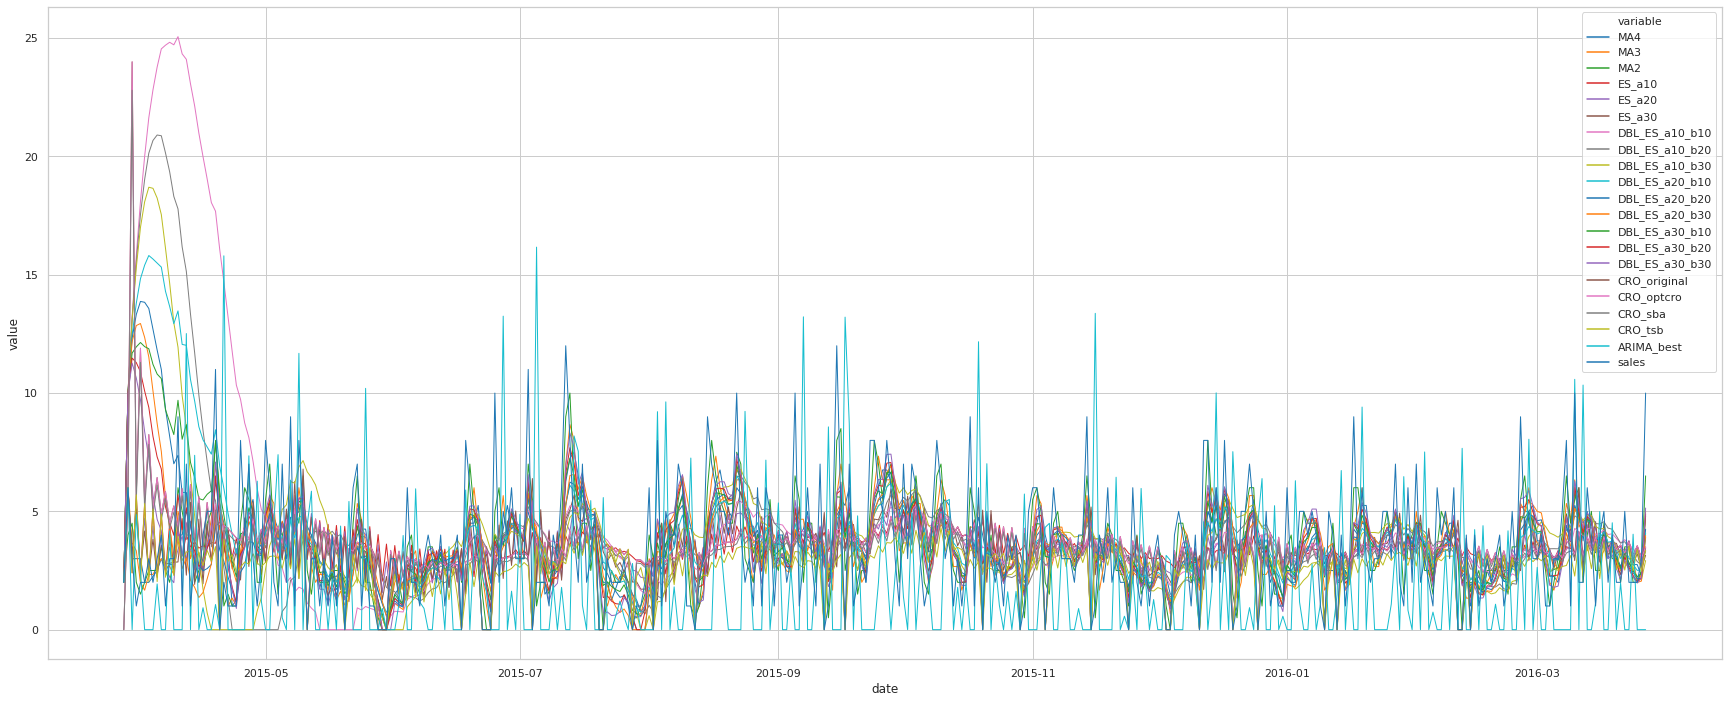

In [ ]:
plot_models(train, mods['in_sample_fits'])

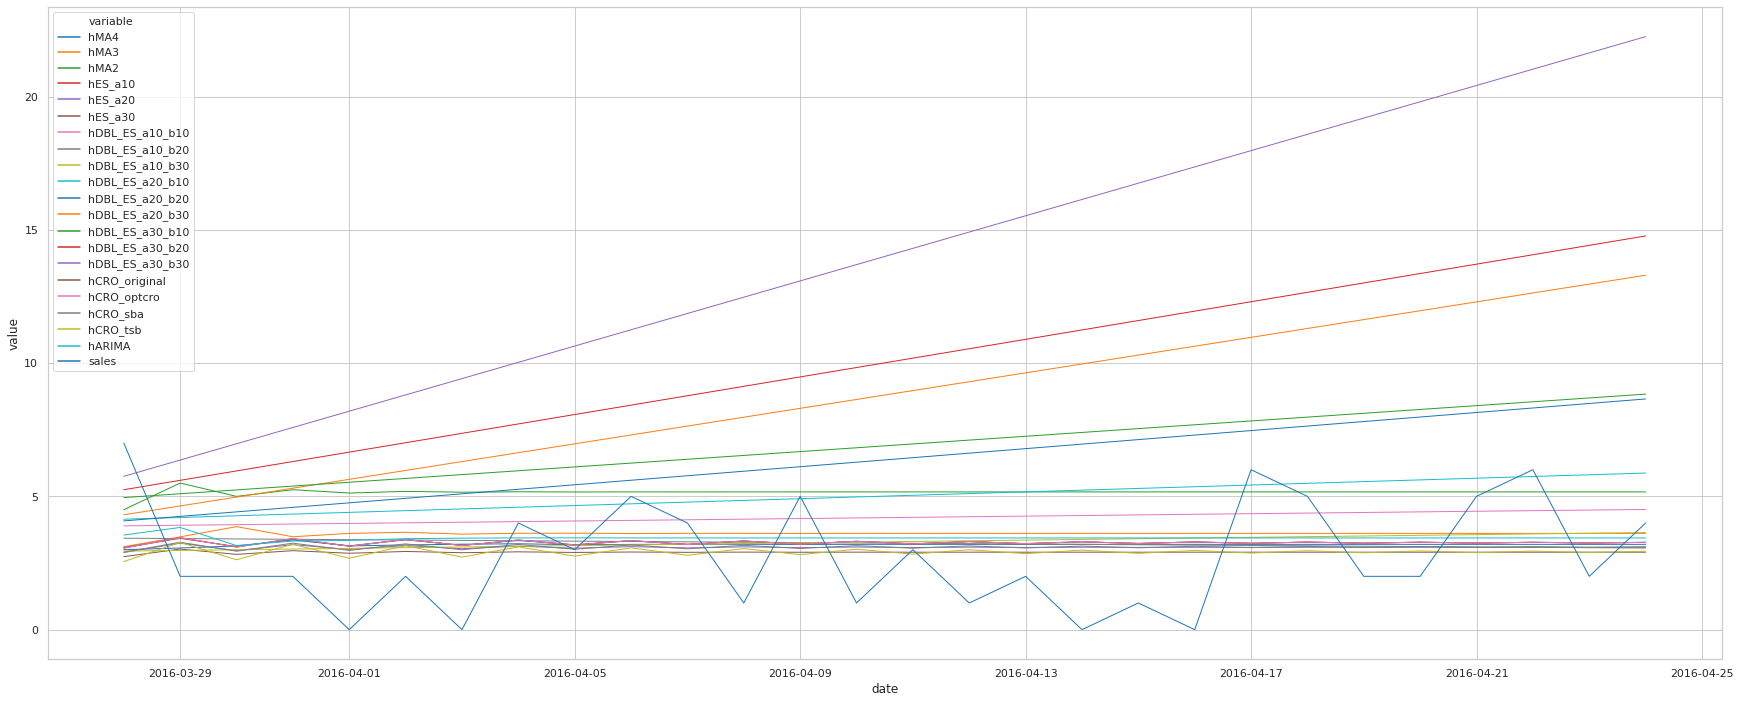

In [ ]:
plot_models(test, mods['forecasts'])

### Loop through all series and record the in sample fits, forecast, and RMSSE

In [ ]:
# Create folders for saving data in your drive
results_path = 'drive/My Drive/m5_forecast_accuracy/outputs2'
save_block_n = 1000
for block in range(0, len(all_id), save_block_n):
  block0 = int(np.round(block / save_block_n))
  new_path = results_path + '/' + str(block)
  %mkdir $new_path

In [ ]:
results_path = 'drive/My Drive/m5_forecast_accuracy/outputs2'

def opt_model_wrapper(df, results_path, idx_start=0, n_train_days=365, all_id=all_id, save_block_n=1000):
  import sys
  save_block = int(idx_start / save_block_n)
  results_path0 = results_path
  results_path = results_path + '/block' + str(save_block)
  

  #all_id = list(df.id.sort_values().unique())
  if idx_start > 0:
    idx_start = save_block * save_block_n
    all_id = all_id[idx_start:]
    print("Starting at timeseries index {} and save block {}.".format(idx_start, save_block))

  t = 0
  print("Training and scoring {} time series.\n".format(str(len(all_id))))
  print("-----------------------------------------")

  for idx in all_id:

    if t % 10 == 0:
      print("Starting series number {}.".format(t+idx_start))
    try:
      train,test = m5_train_test_split(df, idx, n_train_days)
      mods = opt_model(train, test)

      train_merge = train.merge(mods['in_sample_fits'], left_index=True, right_index=True)
      test_merge = test.merge(mods['forecasts'], left_index=True, right_index=True)

      train_rmsse = pd.DataFrame(mods['in_sample_rmsses']).T
      train_rmsse['id'] = idx
      train_rmsse = train_rmsse.set_index('id')

      test_rmsse = pd.DataFrame(mods['forecast_rmsses']).T
      test_rmsse['id'] = idx
      test_rmsse = test_rmsse.set_index('id')

      del train,test,mods

      # Append all results
      if t > 0:
        all_train = all_train.append(train_merge)
        all_test = all_test.append(test_merge)
        all_train_rmsse = all_train_rmsse.append(train_rmsse)
        all_test_rmsse = all_test_rmsse.append(test_rmsse)
      else:
        all_train = train_merge
        all_test = test_merge
        all_train_rmsse = train_rmsse
        all_test_rmsse = test_rmsse

      # Save results every 100 series
      if t % 100 == 0:
        print("Saving series {} results...".format(t+idx_start))
        all_train.to_pickle(results_path + '/benchmark_train.pkl')
        all_test.to_pickle(results_path + '/benchmark_test.pkl')
        all_train_rmsse.to_pickle(results_path + '/benchmark_train_rmsse.pkl')
        all_test_rmsse.to_pickle(results_path + '/benchmark_test_rmsse.pkl')
        print("Saved!")
    except:
      # Dump current progress 
      print("Saving series {} results and printing error...".format(t+idx_start))
      all_train.to_pickle(results_path + '/benchmark_train.pkl')
      all_test.to_pickle(results_path + '/benchmark_test.pkl')
      all_train_rmsse.to_pickle(results_path + '/benchmark_train_rmsse.pkl')
      all_test_rmsse.to_pickle(results_path + '/benchmark_test_rmsse.pkl')
      print("Saved!")
      print("Unexpected error:", sys.exc_info()[0])
      raise

    t+=1
    save_block = int((idx_start + t) / save_block_n)
    results_path = results_path0 + '/block' + str(save_block)

  print("Saving all results...")
  all_train.to_pickle(results_path + '/benchmark_train.pkl')
  all_test.to_pickle(results_path + '/benchmark_test.pkl')
  all_train_rmsse.to_pickle(results_path + '/benchmark_train_rmsse.pkl')
  all_test_rmsse.to_pickle(results_path + '/benchmark_test_rmsse.pkl')
  print('Complete! See results in' + results_path + '/benchmark_test_rmsse.pkl')



In [ ]:
## You may need a couple saves and starts. This notebook was run in Colab
## Took about 32hrs :[
%%time
opt_model_wrapper(df, results_path = results_path, idx_start = 26001, n_train_days=365, all_id = all_id)

Starting at timeseries index 26000 and save block 26.
Training and scoring 4490 time series.

-----------------------------------------
Starting series number 26000.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in true_divide


Saving series 26000 results...
Saved!


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


Starting series number 26010.
Starting series number 26020.
Starting series number 26030.
Starting series number 26040.
Starting series number 26050.


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)


Starting series number 26060.
Starting series number 26070.
Starting series number 26080.
Starting series number 26090.
Starting series number 26100.
Saving series 26100 results...
Saved!
Starting series number 26110.
Starting series number 26120.
Starting series number 26130.
Starting series number 26140.
Starting series number 26150.
Starting series number 26160.
Starting series number 26170.
Starting series number 26180.
Starting series number 26190.
Starting series number 26200.
Saving series 26200 results...
Saved!
Starting series number 26210.
Starting series number 26220.
Starting series number 26230.
Starting series number 26240.
Starting series number 26250.
Starting series number 26260.
Starting series number 26270.
Starting series number 26280.
Starting series number 26290.
Starting series number 26300.
Saving series 26300 results...
Saved!
Starting series number 26310.
Starting series number 26320.
Starting series number 26330.
Starting series number 26340.
Starting series 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:225: RuntimeWarning: divide by zero encountered in log
  Z_mat.astype(complex), R_mat, T_mat)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:225: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat.astype(complex), R_mat, T_mat)


Starting series number 29650.
Starting series number 29660.
Starting series number 29670.
Starting series number 29680.
Starting series number 29690.
Starting series number 29700.
Saving series 29700 results...
Saved!
Starting series number 29710.
Starting series number 29720.
Starting series number 29730.
Starting series number 29740.
Starting series number 29750.
Starting series number 29760.
Starting series number 29770.
Starting series number 29780.
Starting series number 29790.
Starting series number 29800.
Saving series 29800 results...
Saved!
Starting series number 29810.
Starting series number 29820.
Starting series number 29830.
Starting series number 29840.
Starting series number 29850.
Starting series number 29860.
Starting series number 29870.
Starting series number 29880.
Starting series number 29890.
Starting series number 29900.
Saving series 29900 results...
Saved!
Starting series number 29910.
Starting series number 29920.
Starting series number 29930.
Starting series 

### Read random blocks of data back in

In [ ]:
save_block_n = 1000
#n_save_blocks = int(30490 / save_block_n) + 1
n_save_blocks = 10
results_path = 'drive/My Drive/m5_forecast_accuracy/outputs2'

def read_save_blocks(results_path, n_save_blocks = n_save_blocks):

  for save_block0 in range(0,n_save_blocks):
    # Read in random set of save blocks for nn training with replacement
    save_block = np.random.randint(31, size=1)[0]
    print("Reading block {}".format(save_block))
    if save_block0 == 0:
      all_train = pd.read_pickle(results_path + '/block' + str(save_block) + '/benchmark_train.pkl')
      all_test = pd.read_pickle(results_path + '/block' + str(save_block) + '/benchmark_test.pkl')
      all_train_rmsse = pd.read_pickle(results_path + '/block' + str(save_block) + '/benchmark_train_rmsse.pkl')
      all_test_rmsse = pd.read_pickle(results_path + '/block' + str(save_block) + '/benchmark_test_rmsse.pkl')
    else:
      train_merge = pd.read_pickle(results_path + '/block' + str(save_block) + '/benchmark_train.pkl')
      test_merge = pd.read_pickle(results_path + '/block' + str(save_block) + '/benchmark_test.pkl')
      train_rmsse = pd.read_pickle(results_path + '/block' + str(save_block) + '/benchmark_train_rmsse.pkl')
      test_rmsse = pd.read_pickle(results_path + '/block' + str(save_block) + '/benchmark_test_rmsse.pkl')
      all_train = all_train.append(train_merge)
      all_test = all_test.append(test_merge)
      all_train_rmsse = all_train_rmsse.append(train_rmsse)
      all_test_rmsse = all_test_rmsse.append(test_rmsse)
  print("Complete. {} save_blocks read.".format(save_block))
  print("Final training dataset length:{}".format(all_train.shape[0]))
  return([all_train,all_test,all_train_rmsse,all_test_rmsse])

all_train,all_test,all_train_rmsse,all_test_rmsse = read_save_blocks(results_path)


Reading block 25
Reading block 5
Reading block 5
Reading block 9
Reading block 28
Reading block 30
Reading block 10
Reading block 3
Reading block 9
Reading block 4
Complete. 4 save_blocks read.
Final training dataset length:12941643


In [ ]:
## Find worst performing id's. Use these to check for errors and sanity
all_test_rmsse = all_test_rmsse.sort_values('hMA3', ascending=False)
means = all_test_rmsse.mean().sort_values()
print(means)
all_test_rmsse.head()

hDBL_ES_a20_b20     24.525127
hDBL_ES_a30_b10     24.548747
hDBL_ES_a10_b30     24.560115
hMA2                24.569073
hDBL_ES_a20_b30     24.606460
hDBL_ES_a10_b20     24.730084
hDBL_ES_a30_b20     24.744177
hDBL_ES_a20_b10     24.794369
hCRO_optcro         24.848996
hCRO_original       24.894967
hCRO_sba            25.010538
hDBL_ES_a10_b10     25.057291
hDBL_ES_a30_b30     25.302455
hMA3                25.351484
hMA4                25.634140
hES_a30             25.655796
hES_a10             25.674975
hARIMA              25.765811
hES_a20             25.779560
hCRO_tsb            26.080170
CRO_sba            124.285424
CRO_optcro         124.285424
CRO_original       124.285424
DBL_ES_a30_b30     124.285424
DBL_ES_a30_b20     124.285424
DBL_ES_a30_b10     124.285424
DBL_ES_a20_b30     124.285424
DBL_ES_a20_b20     124.285424
DBL_ES_a20_b10     124.285424
DBL_ES_a10_b30     124.285424
DBL_ES_a10_b10     124.285424
ES_a30             124.285424
ES_a20             124.285424
ES_a10    

,hMA4,hMA3,hMA2,hES_a10,hES_a20,hES_a30,hDBL_ES_a10_b10,hDBL_ES_a10_b20,hDBL_ES_a10_b30,hDBL_ES_a20_b10,hDBL_ES_a20_b20,hDBL_ES_a20_b30,hDBL_ES_a30_b10,hDBL_ES_a30_b20,hDBL_ES_a30_b30,hCRO_original,hCRO_optcro,hCRO_sba,hCRO_tsb,hARIMA,MA4,MA3,MA2,ES_a10,ES_a20,ES_a30,DBL_ES_a10_b10,DBL_ES_a10_b20,DBL_ES_a10_b30,DBL_ES_a20_b10,DBL_ES_a20_b20,DBL_ES_a20_b30,DBL_ES_a30_b10,DBL_ES_a30_b20,DBL_ES_a30_b30,CRO_original,CRO_optcro,CRO_sba,CRO_tsb,ARIMA_best
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FOODS_3_635_WI_3_validation,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,8414.079234,8974.127556,9093.154768,11354.671789,10205.59877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_3_635_WI_3_validation,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,8414.079234,8974.127556,9093.154768,11354.671789,10205.59877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_3_635_WI_3_validation,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,8414.079234,8974.127556,9093.154768,11354.671789,10205.59877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_3_635_WI_3_validation,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,8414.079234,8974.127556,9093.154768,11354.671789,10205.59877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FOODS_3_635_WI_3_validation,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,11354.671789,8414.079234,8974.127556,9093.154768,11354.671789,10205.59877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
all_train

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,lag_28,rmean_1_1,rmean_7_1,rmean_28_1,rmean_1_7,rmean_7_7,rmean_28_7,rmean_1_28,rmean_7_28,rmean_28_28,week,quarter,mday,MA4,MA3,MA2,ES_a10,ES_a20,ES_a30,DBL_ES_a10_b10,DBL_ES_a10_b20,DBL_ES_a10_b30,DBL_ES_a20_b10,DBL_ES_a20_b20,DBL_ES_a20_b30,DBL_ES_a30_b10,DBL_ES_a30_b20,DBL_ES_a30_b30,CRO_original,CRO_optcro,CRO_sba,CRO_tsb,ARIMA_best
12188821,FOODS_1_001_CA_1_validation,1536,4,0,2,0,d_1520,0.0,2015-03-28,11509,2,1,3,2015,0,0,0,0,0.0,0.0,0.0,5.320312,0.0,0.0,1.0,0.0,0.0,1.0,0.142857,0.428571,0.285714,0.714286,0.714286,0.607143,13,1,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12188822,FOODS_1_001_CA_1_validation,1536,4,0,2,0,d_1521,0.0,2015-03-29,11509,3,2,3,2015,0,0,0,0,0.0,0.0,0.0,5.320312,0.0,1.0,0.0,0.0,1.0,0.0,0.142857,0.428571,0.285714,0.678571,0.750000,0.607143,13,1,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12188823,FOODS_1_001_CA_1_validation,1536,4,0,2,0,d_1522,0.0,2015-03-30,11509,1,3,3,2015,0,0,0,0,0.0,0.0,0.0,5.320312,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.285714,0.678571,0.750000,0.607143,14,1,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12188824,FOODS_1_001_CA_1_validation,1536,4,0,2,0,d_1523,0.0,2015-03-31,11509,5,4,3,2015,0,0,0,0,0.0,0.0,0.0,5.320312,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.285714,0.678571,0.750000,0.607143,14,1,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12188825,FOODS_1_001_CA_1_validation,1536,4,0,2,0,d_1524,0.0,2015-04-01,11509,6,5,4,2015,0,0,0,0,1.0,1.0,0.0,5.320312,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.142857,0.285714,0.678571,0.714286,0.642857,14,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23220888,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1881,0.0,2016-03-23,11608,6,5,3,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.285714,0.000000,0.107143,0.107143,0.035714,12,1,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23220889,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1882,0.0,2016-03-24,11608,4,6,3,2016,24,3,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.000000,0.107143,0.107143,0.035714,12,1,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23220890,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1883,0.0,2016-03-25,11608,0,7,3,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.000000,0.107143,0.107143,0.035714,12,1,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23434314,HOUSEHOLD_2_516_WI_3_validation,2047,3,9,1,2,d_1884,0.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.142857,0.000000,0.107143,0.107143,0.035714,12,1,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
all_test_rmsse.shape

(4861, 40)

### Plot the output of opt_models_wrapper

In [ ]:
model_cols = ['MA4', 'MA3', 'MA2', 'ES_a10', 'ES_a20', 'ES_a30',
              'DBL_ES_a10_b10', 'DBL_ES_a10_b20', 'DBL_ES_a10_b30',
              'DBL_ES_a20_b10', 'DBL_ES_a20_b20', 'DBL_ES_a20_b30',
              'DBL_ES_a30_b10', 'DBL_ES_a30_b20', 'DBL_ES_a30_b30',
              'CRO_original', 'CRO_optcro', 'CRO_sba', 'CRO_tsb', 
              'ARIMA_best',
              ]
def plot_opt_models_wrapper(plot_df, forecast_df, id, train_rmsse_df, forecast_rmsse_df, model_cols = model_cols, figsize = [30,12]):
  model_cols.append('sales')
  plot_df = plot_df[plot_df.id == id]
  #forecast_df = forecast_df[forecast_df.id == id]
  train_rmsse_df = np.array(train_rmsse_df.loc[id].iloc[0])
  forecast_rmsse_df = np.array(forecast_rmsse_df.loc[id].iloc[0])
  plot_melt = plot_df.melt(id_vars='date', value_vars=model_cols)
  #forecast_melt = forecast_df.melt(id_vars='date', value_vars=model_cols)
  #all_melt = plot_melt.
  labels = []
  
  for model,rmsse in zip(model_cols, train_rmsse_df):
    if model != 'sales':
      labels.append(model + ':' + str(np.around(rmsse, 3)))
  plt.figure(figsize=figsize)
  g = sns.lineplot(data=plot_melt, x='date', y='value', hue='variable', 
                   palette="tab10", linewidth=1, legend = False)
  plt.legend(title='Model:RMSSE', loc='upper left', labels=labels)
  #plt.axvline(x=plot_df.date.max(), c = 'red')
  #plt.axvspan(plot_df.date.min(), plot_df.date.max(), facecolor='gray', alpha=0.3)
  plt.show(g)

In [ ]:
np.array(all_test_rmsse.loc['FOODS_3_635_WI_3_validation'].iloc[0])

array([11354.67178868, 11354.67178868, 11354.67178868, 11354.67178868,
       11354.67178868, 11354.67178868, 11354.67178868, 11354.67178868,
       11354.67178868, 11354.67178868, 11354.67178868, 11354.67178868,
       11354.67178868, 11354.67178868, 11354.67178868,  8414.07923392,
        8974.12755602,  9093.15476765, 11354.67178868, 10205.59876996,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan])

MA4
1.1141783472775115
MA3
1.0026053648615108
MA2
0.8230635673374861
ES_a10
1.496187311324184
ES_a20
1.4314689985642453
ES_a30
1.4192094598875018
DBL_ES_a10_b10
1.244378742879996
DBL_ES_a10_b20
1.2643466695133367
DBL_ES_a10_b30
1.304222341151049
DBL_ES_a20_b10
1.100279028041829
DBL_ES_a20_b20
1.1220834576001952
DBL_ES_a20_b30
1.135596403785672
DBL_ES_a30_b10
0.9716743190578913
DBL_ES_a30_b20
0.9835539301502382
DBL_ES_a30_b30
0.9896619363466825
CRO_original
1.5828012308853034
CRO_optcro
1.5984681815790267
CRO_sba
1.6004226827359123
CRO_tsb
1.4041235486457968
ARIMA_best
2.122727070820802


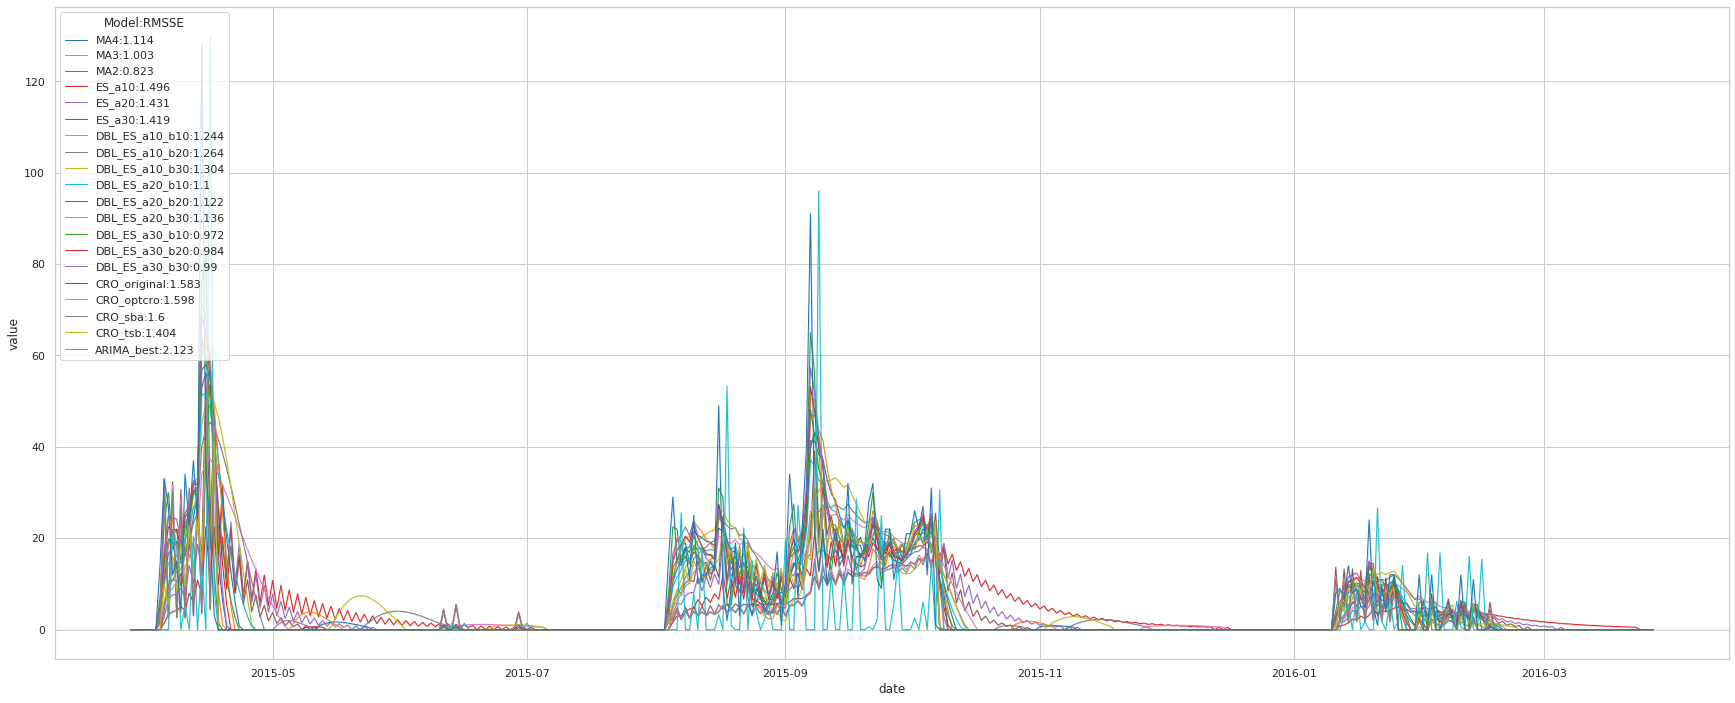

In [ ]:
plot_opt_models_wrapper(all_train, all_test, 'FOODS_3_635_WI_3_validation', all_train_rmsse, all_test_rmsse)

In [ ]:
all_train[all_train.id == 'FOODS_1_103_CA_1_validation']

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,lag_28,rmean_1_1,rmean_7_1,rmean_28_1,rmean_1_7,rmean_7_7,rmean_28_7,rmean_1_28,rmean_7_28,rmean_28_28,week,quarter,mday,MA4,MA3,MA2,ES_a10,ES_a20,ES_a30,DBL_ES_a10_b10,DBL_ES_a10_b20,DBL_ES_a10_b30,DBL_ES_a20_b10,DBL_ES_a20_b20,DBL_ES_a20_b30,DBL_ES_a30_b10,DBL_ES_a30_b20,DBL_ES_a30_b30,CRO_original,CRO_optcro,CRO_sba,CRO_tsb,ARIMA_best
12189521,FOODS_1_103_CA_1_validation,1636,4,0,2,0,d_1520,1.0,2015-03-28,11509,2,1,3,2015,0,0,0,0,0.0,0.0,0.0,4.941406,1.0,1.0,1.0,1.0,1.0,1.0,1.428571,1.142857,1.000000,1.464286,1.357143,1.535714,13,1,28,1.00,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
12189522,FOODS_1_103_CA_1_validation,1636,4,0,2,0,d_1521,0.0,2015-03-29,11509,3,2,3,2015,0,0,0,0,0.0,0.0,0.0,4.941406,1.0,4.0,0.0,1.0,4.0,0.0,1.428571,1.285714,0.714286,1.464286,1.428571,1.464286,13,1,29,0.00,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12189523,FOODS_1_103_CA_1_validation,1636,4,0,2,0,d_1522,1.0,2015-03-30,11509,1,3,3,2015,0,0,0,0,0.0,0.0,0.0,4.941406,0.0,0.0,1.0,0.0,0.0,1.0,0.857143,1.000000,0.714286,1.464286,1.392857,1.500000,14,1,30,1.00,0.666667,0.5,0.900000,0.800000,0.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000
12189524,FOODS_1_103_CA_1_validation,1636,4,0,2,0,d_1523,2.0,2015-03-31,11509,5,4,3,2015,0,0,0,0,0.0,0.0,0.0,4.941406,1.0,4.0,7.0,1.0,4.0,7.0,1.000000,1.285714,1.714286,1.464286,1.535714,1.750000,14,1,31,1.00,1.000000,1.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,5.000000,4.750000,0.000000,0.000000
12189525,FOODS_1_103_CA_1_validation,1636,4,0,2,0,d_1524,2.0,2015-04-01,11509,6,5,4,2015,0,0,0,0,1.0,1.0,0.0,4.941406,2.0,0.0,1.0,2.0,0.0,1.0,0.714286,1.285714,1.857143,1.285714,1.535714,1.750000,14,2,1,1.25,1.666667,2.0,1.010000,1.040000,1.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.578947,0.578947,0.550000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029508,FOODS_1_103_CA_1_validation,1636,4,0,2,0,d_1881,3.0,2016-03-23,11608,6,5,3,2016,0,0,0,0,0.0,0.0,0.0,4.941406,2.0,1.0,2.0,2.0,1.0,2.0,2.857143,0.714286,2.285714,1.535714,1.357143,2.142857,12,1,23,2.50,2.000000,2.5,1.659540,1.834761,2.072343,2.088828,2.725586,3.188282,2.938104,3.430255,3.775170,3.077615,3.388229,3.499689,1.602575,1.602575,1.522446,1.167276,0.000000
23029509,FOODS_1_103_CA_1_validation,1636,4,0,2,0,d_1882,0.0,2016-03-24,11608,4,6,3,2016,24,3,0,0,0.0,0.0,0.0,4.941406,3.0,3.0,2.0,3.0,3.0,2.0,3.142857,1.142857,2.142857,1.571429,1.357143,2.107143,12,1,24,1.50,1.666667,1.5,1.972356,2.390612,2.676632,1.930781,2.601571,3.033681,2.411662,2.815520,3.027048,2.175367,2.317133,2.224376,0.000000,0.000000,0.000000,0.000000,0.000000
23029510,FOODS_1_103_CA_1_validation,1636,4,0,2,0,d_1883,1.0,2016-03-25,11608,0,7,3,2016,0,0,0,0,0.0,0.0,0.0,4.941406,0.0,2.0,1.0,0.0,2.0,1.0,2.714286,1.428571,1.285714,1.500000,1.178571,2.035714,12,1,25,1.50,1.333333,0.5,1.493586,1.467809,1.450640,1.879231,2.557926,2.933530,2.162274,2.451111,2.506927,1.808533,1.788337,1.521463,1.820584,1.820584,1.729555,1.271801,3.736914
23242934,FOODS_1_103_CA_1_validation,1636,4,0,2,0,d_1884,2.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,4.941406,1.0,7.0,1.0,1.0,7.0,1.0,2.571429,2.428571,1.428571,1.500000,1.428571,2.035714,12,1,26,1.50,1.000000,1.5,1.875120,2.11248

In [ ]:
all_test_rmsse.index

Index(['FOODS_1_001_CA_1_validation', 'FOODS_1_001_CA_2_validation',
       'FOODS_1_001_CA_3_validation', 'FOODS_1_001_CA_4_validation',
       'FOODS_1_001_TX_1_validation', 'FOODS_1_001_TX_2_validation',
       'FOODS_1_001_TX_3_validation', 'FOODS_1_001_WI_1_validation',
       'FOODS_1_001_WI_2_validation', 'FOODS_1_001_WI_3_validation',
       ...
       'FOODS_1_102_CA_2_validation', 'FOODS_1_102_CA_3_validation',
       'FOODS_1_102_CA_4_validation', 'FOODS_1_102_TX_1_validation',
       'FOODS_1_102_TX_2_validation', 'FOODS_1_102_TX_3_validation',
       'FOODS_1_102_WI_1_validation', 'FOODS_1_102_WI_2_validation',
       'FOODS_1_102_WI_3_validation', 'FOODS_1_103_CA_1_validation'],
      dtype='object', name='id', length=1001)

In [ ]:
all_test

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,lag_28,rmean_1_1,rmean_7_1,rmean_28_1,rmean_1_7,rmean_7_7,rmean_28_7,rmean_1_28,rmean_7_28,rmean_28_28,week,quarter,mday,hMA4,hMA3,hMA2,hES_a10,hES_a20,hES_a30,hDBL_ES_a10_b10,hDBL_ES_a10_b20,hDBL_ES_a10_b30,hDBL_ES_a20_b10,hDBL_ES_a20_b20,hDBL_ES_a20_b30,hDBL_ES_a30_b10,hDBL_ES_a30_b20,hDBL_ES_a30_b30,hCRO_original,hCRO_optcro,hCRO_sba,hCRO_tsb,hARIMA,MA4,MA3,MA2,ES_a10,ES_a20,ES_a30,DBL_ES_a10_b10,DBL_ES_a10_b20,DBL_ES_a10_b30,DBL_ES_a20_b10,DBL_ES_a20_b20,DBL_ES_a20_b30,DBL_ES_a30_b10,DBL_ES_a30_b20,DBL_ES_a30_b30,CRO_original,CRO_optcro,CRO_sba,CRO_tsb,ARIMA_best
23246436,FOODS_2_386_CA_1_validation,2212,5,0,2,0,d_1886,2.0,2016-03-28,11609,1,3,3,2016,0,0,0,0,0.0,0.0,0.0,2.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.714286,0.285714,0.785714,0.750000,0.142857,13,1,28,0.500000,0.666667,1.000000,0.000000,0.000000,0.000000,0.614165,0.000000,0.000000,0.574197,0.651779,0.861138,0.628283,0.713934,0.734104,0.000000,0.000000,0.000000,0.000000,0.558159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23246437,FOODS_2_386_CA_1_validation,2212,5,0,2,0,d_1887,2.0,2016-03-29,11609,5,4,3,2016,0,0,0,0,0.0,0.0,0.0,2.500000,2.0,0.0,2.0,2.0,0.0,2.0,0.714286,0.571429,0.428571,0.857143,0.714286,0.214286,13,1,29,0.562500,0.777778,1.000000,0.763084,0.919794,0.981115,0.602016,0.000000,0.000000,0.570779,0.675828,0.915100,0.630268,0.731094,0.739317,0.571701,0.571701,0.543116,0.611775,0.573641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23246438,FOODS_2_386_CA_1_validation,2212,5,0,2,0,d_1888,1.0,2016-03-30,11609,6,5,3,2016,0,0,0,0,0.0,0.0,0.0,2.500000,2.0,0.0,3.0,2.0,0.0,3.0,1.000000,0.571429,0.714286,0.857143,0.678571,0.321429,13,1,30,0.640625,0.703704,1.000000,0.000000,0.539320,0.641071,0.589867,0.000000,0.000000,0.567361,0.699878,0.969062,0.632253,0.748253,0.744530,0.000000,0.000000,0.000000,0.000000,0.572283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23246439,FOODS_2_386_CA_1_validation,2212,5,0,2,0,d_1889,0.0,2016-03-31,11609,4,6,3,2016,0,0,0,0,0.0,0.0,0.0,2.500000,1.0,1.0,0.0,1.0,1.0,0.0,1.142857,0.714286,0.714286,0.785714,0.714286,0.321429,13,1,31,0.613281,0.716049,1.000000,0.732642,0.843699,0.879102,0.577718,0.000000,0.000000,0.563944,0.723927,1.023023,0.634238,0.765413,0.749743,0.546664,0.546664,0.519331,0.541957,0.570484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23246440,FOODS_2_386_CA_1_validation,2212,5,0,2,0,d_1890,0.0,2016-04-01,11609,0,7,4,2016,0,0,0,0,1.0,1.0,0.0,2.500000,0.0,0.0,2.0,0.0,0.0,2.0,1.000000,0.714286,1.000000,0.785714,0.714286,0.392857,13,2,1,0.579102,0.732510,1.000000,0.000000,0.600196,0.712480,0.565569,0.000000,0.000000,0.560526,0.747976,1.076985,0.636222,0.782573,0.754956,0.000000,0.000000,0.000000,0.000000,0.568750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23889458,FOODS_3_378_CA_1_validation,2602,6,0,2,0,d_1909,2.0,2016-04-20,11612,6,5,4,2016,0,0,0,0,0.0,0.0,0.0,4.679688,0.0,0.0,0.0,0.0,0.0,0.0,1.142857,1.142857,1.571429,1.642857,1.750000,1.392857,16,2,20,1.824991,2.444444,2.833333,1.618954,1.732357,1.898802,1.920346,2.524461,4.004896,2.684898,3.955441,4.788305,3.135945,4.378919,5.153808,1.573086,1.692642,1.608010,0.889533,1.888552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23889459,FOODS_3_378_CA_1_validation,2602,6,0,2,0,d_1910,0.0,2016-04-21,11612,4,6,4,2016,0,0,0,0,0.0,0.0,0.0,4.679688,2.0,4.0,1.0,2.0,4.0,1.0

In [ ]:
all_train[all_train['id'] == all_id[1010]]

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,lag_28,rmean_1_1,rmean_7_1,rmean_28_1,rmean_1_7,rmean_7_7,rmean_28_7,rmean_1_28,rmean_7_28,rmean_28_28,week,quarter,mday,MA4,MA3,MA2,ES_a10,ES_a20,ES_a30,DBL_ES_a10_b10,DBL_ES_a10_b20,DBL_ES_a10_b30,DBL_ES_a20_b10,DBL_ES_a20_b20,DBL_ES_a20_b30,DBL_ES_a30_b10,DBL_ES_a30_b20,DBL_ES_a30_b30,CRO_original,CRO_optcro,CRO_sba,CRO_tsb,ARIMA_best
12189528,FOODS_1_104_CA_1_validation,1637,4,0,2,0,d_1520,2.0,2015-03-28,11509,2,1,3,2015,0,0,0,0,0.0,0.0,0.0,1.480469,3.0,1.0,4.0,3.0,1.0,4.0,1.857143,2.428571,2.571429,2.392857,2.464286,3.428571,13,1,28,2.00,2.000000,2.0,2.000000,2.000000,2.00,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2.00,2.000000
12189529,FOODS_1_104_CA_1_validation,1637,4,0,2,0,d_1521,8.0,2015-03-29,11509,3,2,3,2015,0,0,0,0,0.0,0.0,0.0,1.480469,2.0,5.0,8.0,2.0,5.0,8.0,2.000000,2.714286,3.428571,2.321429,2.571429,3.571429,13,1,29,8.00,8.000000,5.0,8.000000,8.000000,8.00,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,8.000000,8.000000,6.800000,8.00,8.000000
12189530,FOODS_1_104_CA_1_validation,1637,4,0,2,0,d_1522,0.0,2015-03-30,11509,1,3,3,2015,0,0,0,0,0.0,0.0,0.0,1.480469,8.0,2.0,0.0,8.0,2.0,0.0,2.428571,2.571429,3.142857,2.321429,2.571429,3.321429,14,1,30,0.00,3.333333,4.0,2.600000,3.200000,3.80,18.460000,18.320000,18.180000,16.920000,16.640000,16.360000,15.380000,14.960000,14.540000,0.000000,0.000000,0.000000,0.00,0.000000
12189531,FOODS_1_104_CA_1_validation,1637,4,0,2,0,d_1523,3.0,2015-03-31,11509,5,4,3,2015,0,0,0,0,0.0,0.0,0.0,1.480469,0.0,1.0,0.0,0.0,1.0,0.0,2.142857,2.285714,2.714286,2.321429,2.500000,3.214286,14,1,31,3.25,3.666667,1.5,7.200000,6.400000,5.60,22.619400,22.201600,21.786600,19.577600,18.806400,18.046400,16.874600,15.814400,14.779400,26.000000,11.666667,9.916667,3.15,9.163511
12189532,FOODS_1_104_CA_1_validation,1637,4,0,2,0,d_1524,6.0,2015-04-01,11509,6,5,4,2015,0,0,0,0,1.0,1.0,0.0,1.480469,3.0,1.0,2.0,3.0,1.0,2.0,2.428571,1.857143,2.714286,2.428571,2.464286,3.250000,14,2,1,4.25,3.000000,4.5,2.640000,3.160000,3.56,26.496666,25.671008,24.858942,22.032128,20.627264,19.272736,18.494582,16.723616,15.056834,6.818182,5.192308,4.413462,6.75,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029515,FOODS_1_104_CA_1_validation,1637,4,0,2,0,d_1881,0.0,2016-03-23,11608,6,5,3,2016,0,0,0,0,0.0,0.0,0.0,1.480469,0.0,0.0,3.0,0.0,0.0,3.0,0.142857,0.000000,1.571429,1.178571,1.428571,3.000000,12,1,23,0.00,0.000000,0.0,1.007606,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
23029516,FOODS_1_104_CA_1_validation,1637,4,0,2,0,d_1882,0.0,2016-03-24,11608,4,6,3,2016,24,3,0,0,0.0,0.0,0.0,1.480469,0.0,0.0,1.0,0.0,0.0,1.0,0.142857,0.000000,1.285714,1.071429,1.321429,2.857143,12,1,24,0.00,0.000000,0.0,1.419354,0.655181,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
23029517,FOODS_1_104_CA_1_validation,1637,4,0,2,0,d_1883,0.0,2016-03-25,11608,0,7,3,2016,0,0,0,0,0.0,0.0,0.0,1.480469,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,1.000000,1.035714,1.250000,2.785714,12,1,25,0.00,0.000000,0.0,0.906846,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
23242941,FOODS_1_104_CA_1_validation,1637,4,0,2,0,d_1884,0.0,2016-03-26,11609,2,1,3,2016,0,0,0,0,0.0,0.0,0.0,1.480469,0.0,1.0,5.0,0.0,1.0,5.0,0.142857,0.142857,1.571429,1.035714,1.250000,2.928571,12,1,26,0.00,0.000000,0.0,1.277418,0.524145,0.00,0.000000,0.000000,0

In [ ]:
all_train.columns

Index(['id', 'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_1', 'lag_7',
       'lag_28', 'rmean_1_1', 'rmean_7_1', 'rmean_28_1', 'rmean_1_7',
       'rmean_7_7', 'rmean_28_7', 'rmean_1_28', 'rmean_7_28', 'rmean_28_28',
       'week', 'quarter', 'mday', 'MA4', 'MA3', 'MA2', 'ES_a10', 'ES_a20',
       'ES_a30', 'DBL_ES_a10_b10', 'DBL_ES_a10_b20', 'DBL_ES_a10_b30',
       'DBL_ES_a20_b10', 'DBL_ES_a20_b20', 'DBL_ES_a20_b30', 'DBL_ES_a30_b10',
       'DBL_ES_a30_b20', 'DBL_ES_a30_b30', 'CRO_original', 'CRO_optcro',
       'CRO_sba', 'CRO_tsb', 'ARIMA_best'],
      dtype='object')

#Section 3: RNN-Gated Recurrent Unit
With a sample of the data, train a NN for time series prediction (Section Incomplete)

### Train and Test set

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Select columns desired for gru nn
train_cols = ['sales','dept_id',
              'store_id',
              'cat_id',
              'state_id',
              'weekday',
              'month',
              'event_name_1',
              'event_type_1',
              'event_name_2',
              'event_type_2',
              'snap_CA',
              'snap_TX',
              'snap_WI',
              'sell_price',
              'MA4',
              'MA3',
              'MA2',
              'ES_a10',
              'ES_a20',
              'ES_a30',
              'DBL_ES_a10_b10',
              'DBL_ES_a10_b20',
              'DBL_ES_a10_b30',
              'DBL_ES_a20_b10', 
              'DBL_ES_a20_b20', 
              'DBL_ES_a20_b30', 
              'DBL_ES_a30_b10',
              'DBL_ES_a30_b20',
              'DBL_ES_a30_b30',
              'CRO_original',
              'CRO_optcro',
              'CRO_sba',
              'CRO_tsb',
              'ARIMA_best',
]
test_cols = ['sales','dept_id',
              'store_id',
              'cat_id',
              'state_id',
              'weekday',
              'month',
              'event_name_1',
              'event_type_1',
              'event_name_2',
              'event_type_2',
              'snap_CA',
              'snap_TX',
              'snap_WI',
              'sell_price',
              'hMA4',
              'hMA3',
              'hMA2',
              'hES_a10',
              'hES_a20',
              'hES_a30',
              'hDBL_ES_a10_b10',
              'hDBL_ES_a10_b20',
              'hDBL_ES_a10_b30',
              'hDBL_ES_a20_b10', 
              'hDBL_ES_a20_b20', 
              'hDBL_ES_a20_b30', 
              'hDBL_ES_a30_b10',
              'hDBL_ES_a30_b20',
              'hDBL_ES_a30_b30',
              'hCRO_original',
              'hCRO_optcro',
              'hCRO_sba',
              'hCRO_tsb',
              'hARIMA',
]
train = np.array(all_train[train_cols])
test = np.array(all_test[test_cols])
# Replace nanss
train[np.isnan(train)] = 0
test[np.isnan(test)] = 0
y = np.array(all_train.sales)
y_test = np.array(all_test.sales)
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [ ]:
np.sum(np.isnan(test))

0

In [ ]:
np.sum(np.isnan(all_test[test_cols]))

dept_id               0
store_id              0
cat_id                0
state_id              0
weekday               0
month                 0
event_name_1          0
event_type_1          0
event_name_2          0
event_type_2          0
snap_CA               0
snap_TX               0
snap_WI               0
sell_price            0
hMA4               2016
hMA3               2016
hMA2               2016
hES_a10            2016
hES_a20            2016
hES_a30            2016
hDBL_ES_a10_b10    2016
hDBL_ES_a10_b20    2016
hDBL_ES_a10_b30    2016
hDBL_ES_a20_b10    2016
hDBL_ES_a20_b20    2016
hDBL_ES_a20_b30    2016
hDBL_ES_a30_b10    2016
hDBL_ES_a30_b20    2016
hDBL_ES_a30_b30    2016
hCRO_original      2016
hCRO_optcro        2016
hCRO_sba           2016
hCRO_tsb           2016
hARIMA             2016
dtype: int64

In [ ]:
test

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.05910080e-03, 3.29371425e-03, 1.74830238e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.20918072e-04, 0.00000000e+00, 1.62917105e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.01434291e-03, 3.16757054e-03, 1.64568595e-03],
       ...,
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.91059064e-03, 5.13690944e-03, 4.89567497e-03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.94752384e-03, 5.12505005e-03, 4.89567497e-03],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.91422067e-03, 5.13572315e-03, 4.89567497e-03]])

In [ ]:
train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.        , 0.        , ..., 0.0011157 , 0.0029994 ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.00232754, 0.00500809,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.00167291, 0.00523837,
        0.        ]])

### TimeseriesGenerator
Creates a series based on input parameters but outputs an object not all tf functions can ingest

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
seq_len = 365 + 1
# Shuffle here is important because we do not want to train on the full dataset
# Given that many of the series are 0, the input data is somewhat unbalanced
generator = TimeseriesGenerator(train, y, length=seq_len, batch_size=1, shuffle=True)
validation_generator = TimeseriesGenerator(test, y_test, length=seq_len, batch_size=1, shuffle=True)

In [ ]:
X, y = generator[14]
print(f'Given the Array: \n{X.flatten()}')
print(f'Shape: {X.shape}')
print(f'Flat shape: {X.flatten().shape}')
print(f'Predict this y: \n {y}')
print(f'Shape: {y.shape}')
X, y = validation_generator[14]
print(f'Given the Array: \n{X.flatten()}')
print(f'Shape: {X.shape}')
print(f'Flat shape: {X.flatten().shape}')
print(f'Predict this y: \n {y}')
print(f'Shape: {y.shape}')

Given the Array: 
[1.         0.22222222 1.         ... 0.         0.         0.        ]
Shape: (1, 366, 34)
Flat shape: (12444,)
Predict this y: 
 [0.]
Shape: (1,)
Given the Array: 
[0.83333333 0.11111111 1.         ... 0.         0.         0.        ]
Shape: (1, 366, 34)
Flat shape: (12444,)
Predict this y: 
 [0.]
Shape: (1,)


### Create time series sequences and target
Benefits from being a standard tuple with numpy objects instead of a timeseriesgenerator object. More portable

In [ ]:
seq_len = 365 + 1
batch_size = 100
buffer_size = 10000

tf_dataset = tf.data.Dataset.from_tensor_slices(train)
sequences = tf_dataset.batch(seq_len, drop_remainder = True)

# Get the last sales data as the target
def create_seq_targets(seq):
  inputs = seq[:-1]
  target = seq[-1:][0][0]
  return inputs, target

dataset = sequences.map(create_seq_targets)
dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
# See that it shifted forward 1
for inputs, target in dataset.take(1):
  print(pd.DataFrame(inputs.numpy()[:,0]))
  print('\n')
  print(target)

          0    1         2    3   ...        31        32        33        34
0   0.003096  0.8  0.333333  1.0  ...  0.000000  0.000000  0.000000  0.000000
1   0.000000  0.8  0.222222  1.0  ...  0.000000  0.000000  0.000000  0.004011
2   0.006192  0.2  0.333333  0.5  ...  0.000000  0.000000  0.000000  0.000000
3   0.000000  0.8  0.222222  1.0  ...  0.000000  0.000000  0.000000  0.000000
4   0.003096  0.8  0.333333  1.0  ...  0.000000  0.000000  0.000000  0.004014
..       ...  ...       ...  ...  ...       ...       ...       ...       ...
95  0.000000  0.2  0.333333  0.5  ...  0.000000  0.000000  0.000000  0.000000
96  0.000000  0.8  0.666667  1.0  ...  0.000000  0.000000  0.000000  0.000000
97  0.009288  0.2  0.555556  0.5  ...  0.010255  0.010255  0.055276  0.000000
98  0.000000  0.2  0.444444  0.5  ...  0.000000  0.000000  0.000000  0.000000
99  0.000000  0.0  0.333333  0.0  ...  0.000000  0.000000  0.000000  0.000000

[100 rows x 35 columns]


tf.Tensor(
[0.         0.00309598 0. 

In [ ]:
dataset.take(1)

<TakeDataset shapes: ((100, 365, 35), (100,)), types: (tf.float64, tf.float64)>

In [ ]:
# Make a directory for saving model checkpoints
!mkdir -p saved_model
!mkdir -p 'saved_model/m5_chkpts'
!ls

drive  sample_data  saved_model


### Create and fit model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,GRU,Flatten
def create_model(input_shape, out_shape, lt_red_dim, rnn_neurons):
  model = Sequential()
  #model.add(Flatten(input_shape=input_shape))
  model.add(Dropout(0.2,input_shape=input_shape))
  model.add(Dense(lt_red_dim,input_shape=input_shape))
  model.add(GRU(rnn_neurons, activation='relu', return_sequences=True, reset_after=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform'))
  #model.add(Dense(int(lt_red_dim/2), input_shape=input_shape))
  #model.add(GRU(int(rnn_neurons/2), activation='relu', return_sequences=True, reset_after=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform'))
  model.add(Dense(out_shape))
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
model = create_model(
    input_shape = (seq_len,len(train_cols)),
    out_shape = 1, 
    lt_red_dim = int((seq_len*len(train_cols)) / 2),
    rnn_neurons = 500,
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 366, 6222)         217770    
_________________________________________________________________
gru_5 (GRU)                  (None, 366, 500)          10086000  
_________________________________________________________________
dense_7 (Dense)              (None, 366, 3111)         1558611   
_________________________________________________________________
gru_6 (GRU)                  (None, 366, 250)          2522250   
_________________________________________________________________
dense_8 (Dense)              (None, 366, 1)            251       
Total params: 14,384,882
Trainable params: 14,384,882
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2 = create_model(
    input_shape = (seq_len-1,len(train_cols)),
    out_shape = 1, 
    lt_red_dim = int(((seq_len-1)*len(train_cols)) / 2),
    rnn_neurons = 500,
)
model2.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_9 (Dropout)          (None, 365, 35)           0         
_________________________________________________________________
dense_25 (Dense)             (None, 365, 6387)         229932    
_________________________________________________________________
gru_13 (GRU)                 (None, 365, 500)          10333500  
_________________________________________________________________
dense_26 (Dense)             (None, 365, 1)            501       
Total params: 10,563,933
Trainable params: 10,563,933
Non-trainable params: 0
_________________________________________________________________


### Callback for logging loss history

In [ ]:
class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.val_losses = []

  def on_batch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
  
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2, max_delta=0.01)

history = LossHistory()

### Train RNN while periodically saving progress

In [ ]:
epochs=10
save_step = 5
ep = 0
history = LossHistory()
while ep <= epochs:
  model2.fit(dataset,epochs=save_step,
            # TODO?: Getting a hang when using validation_data. Unresolved
            validation_data=dataset,
            validation_steps = 100,
            callbacks=[history, early_stop],
            # Complete 100 series per Epoch and update gradient
            #steps_per_epoch = 100,
            )
  if ep <= epochs:
    # Mount your drive on the left panel and save model there
    try:
      model2.save('drive/My Drive/m5_forecast_accuracy/saved_models/rnn_red_ep{}'.format(ep))
      print('-----> Epoch {} saved. <-----'.format(ep))
    except:
      print("Unable to save results. Fix the save location.")
  ep += save_step
model2.save('drive/My Drive/m5_forecast_accuracy/saved_models/rnn_red_ep{}'.format(ep))

In [ ]:
pd.Series(history.losses).plot()
print(len(history.losses))

In [ ]:
# Tarball model data
!tar -zcvf [].tgz 'drive/My Drive/saved_models/...'

In [ ]:
# Download model data to your local computer for your safe keeping
from google.colab import files
files.download('conan_rnn_chkpt_ep200.tgz')

In [ ]:
from tensorflow.keras.models import load_model
model_loaded = load_model('drive/My Drive/m5_forecast_accuracy/saved_models/rnn_red_ep0')
#model_loaded.save('drive/My Drive/saved_models/conan_rnn/conan_rnn_ep250/conan_rnn_chkpt_ep250.h5')
model_loaded.summary()

In [ ]:
# Function takes the start seed and appends prediction output to it for the desired number of predictions.
# Be sure that the start seed is the necessary dimension for your model
def generate_forecast(model, start_seed, h=28):

  # Expand to match batch format shape
  #input_eval = tf.expand_dims(start_seed, 0)

  new_x = []

  model.reset_states()

  for i in range(h):

    #tf.convert_to_tensor(arg, dtype=tf.float32)

    input_eval.reshape()

    predictions = model.predict(start_seed)

    # Fix dims
    predictions = tf.squeeze(predictions, 0)

    #input_eval = tf.expand_dims([predictions], 0)

    # Transform back to char
    new_x.append(predictions)

  return(new_x)

In [ ]:
model_loaded.compile(optimizer='adam', loss='mse')

In [ ]:
start_seed = dataset.unbatch().take(3)
#start_seed = np.stack(list(start_seed))
start_seed
#start_seed = start_seed.numpy()
#tf.convert_to_tensor(start_seed)

<TakeDataset shapes: ((365, 35), ()), types: (tf.float64, tf.float64)>

In [ ]:
generate_forecast(model_loaded, start_seed, h=28)